# compute spectra from single drifter tracks

In [1]:
import os
from glob import glob
import pickle

import numpy as np
import xarray as xr
import dask.bag as db
import pandas as pd

from scipy import signal
from mtspec import mtspec
import nitime.algorithms as tsa
from scipy.fftpack import fftfreq

from matplotlib import pyplot as plt
%matplotlib inline

import mitequinox.drifters as edr
import mitequinox.utils as eut

#data_dir = '/work/ALT/swot/aval/syn/drifters/'
data_dir = eut.work_data_dir+'drifters/'
aviso_dir = '/work/ALT/odatis/AVISO/2019/'

In [2]:
from dask_jobqueue import PBSCluster
#cluster = PBSCluster(cores=6, walltime='12:00:00', memory='20GB')
cluster = PBSCluster()
w = cluster.scale(1*12)
#w = cluster.scale(10) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client()

In [4]:
#client
cluster

In [9]:
#client.close()
cluster.close()

---
## utils

In [5]:
lon_bins = np.arange(-180.5, 180.5, 1.)
lat_bins = np.arange(-90.5, 91.5, 1.)

lon_c = (lon_bins[:-1]+lon_bins[1:])*.5
lat_c = (lat_bins[:-1]+lat_bins[1:])*.5

lon_idx = pd.IntervalIndex.from_breaks(lon_bins)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
lonlat_idx = pd.MultiIndex.from_product([lon_idx, lat_idx])

---

## load raw data as xarray dataset and then a dataframe

In [8]:
ads = xr.open_mfdataset(aviso_dir+'*.nc', concat_dim='time', parallel=True)
ads

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 12)
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-01-12
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, latitude, nv) float32 dask.array<shape=(12, 720, 2), chunksize=(1, 720, 2)>
    lon_bnds   (time, longitude, nv) float32 dask.array<shape=(12, 1440, 2), chunksize=(1, 1440, 2)>
    err        (time, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    adt        (time, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(12, 720, 1440), chunksize=(1, 720, 1440)>
    vgos       (

In [6]:
ds = xr.open_mfdataset(data_dir+'single_tfilt/low_inertial_*.nc', 
                       concat_dim='index', parallel=True)

In [7]:
ds = ds.chunk({'index': 500})
ds['UV'] = (ds.U + 1j * ds.V).where(~np.isnan(ds.U*ds.V), other=np.nan)
ds['f'] = eut.coriolis(ds.LAT, signed=True)
ds['depth'] = edr.compute_depth(ds.LON, ds.LAT)

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/pandas/core/indexes/base.py:2825: RuntimeWarning: invalid value encountered in less
  indexer = np.where(op(left_distances, right_distances) |


In [8]:
ds = ds.persist()

check typical percentages of bad points

(array([   21.,    18.,    13.,    17.,    28.,    32.,    26.,    34.,
           65., 11073.]),
 array([0.9001387 , 0.91012483, 0.92011096, 0.93009709, 0.94008322,
        0.95006935, 0.96005548, 0.97004161, 0.98002774, 0.99001387,
        1.        ]),
 <a list of 10 Patch objects>)

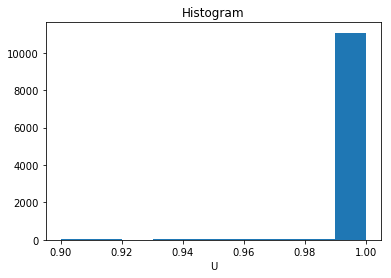

In [9]:
gd_points_percent = ( ds.U.where(np.isnan(ds.U), other=1.)
                      .fillna(0.).sum('TIME')/len(ds.TIME) )
gd_points_percent.plot.hist()

In [10]:
# interpolate NaNs
ds['UV'] = ds.UV.fillna(0.)
# below not working, xarray version issue?
#ds['UV'] = ds.UV.interpolate_na(dim='TIME', method='linear', 
#                                limit=12, right=0., left=0.)

---

## compute spectra

In [12]:
def _get_E(x, ufunc=True, **kwargs):
    #ax = -1 if ufunc else 0
    #ax = -1
    #dkwargs = {'window': 'hann', 'return_onesided': False, 
    #           'detrend': 'linear', 'scaling': 'density'}
    #dkwargs.update(kwargs)
    #f, E = signal.periodogram(x, fs=24., axis=ax, **dkwargs)
    #
    #E = []
    #for i in range(x.shape[0]):
    #    lE, f = mtspec(data=x[i,:], delta=1/24., time_bandwidth=4.,
    #                  number_of_tapers=6, quadratic=True)
    #    E+=[lE[None,:]]
    #E = np.concatenate(E,axis=0)
    lf, E, nu = tsa.multi_taper_psd(x, Fs=24., NW=4, sides='twosided',
                                   adaptive=False, jackknife=False)
    f = fftfreq(len(lf))*24.
    # http://nipy.org/nitime/examples/multi_taper_spectral_estimation.html
    #print(nu[2])
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    Nb = len(v.TIME)
    #Nb = 361
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['TIME']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')
    
x = ds.UV.isel(index=slice(0,10)).values
print(x.shape)
f, E = _get_E(x, ufunc=False)
E.shape

(10, 721)


/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/nitime/algorithms/spectral.py:551: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an er

(10, 721)

In [16]:
f, E = get_E(ds.UV.isel(index=slice(0,10)))
ds['E'] = get_E(ds.UV,f=f).persist()

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


In [17]:
ds.E.values.shape

(11327, 721)

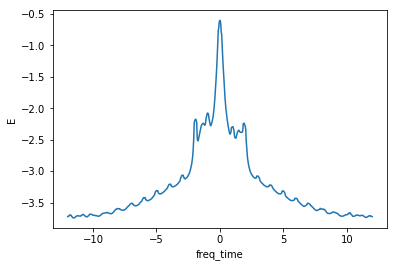

In [18]:
np.log10(ds.E.mean('index')).plot()

## bin per latitude

In [45]:
#ds = ds.isel(index=slice(0,1000))

In [19]:
ds = ds.assign_coords(LAT_mean=ds.LAT.mean('TIME'))
ds = ds.assign_coords(depth_mean=ds.depth.mean('TIME'))

In [20]:
ds = ds.where(ds.depth_mean>500, drop=True)

In [21]:
E = (ds.E.groupby_bins(ds.LAT_mean, lat_bins, labels= lat_c).mean(dim='index')
     .rename({'LAT_mean_bins': 'lat'}).persist() )
E

<xarray.DataArray 'E' (lat: 181, freq_time: 721)>
dask.array<shape=(181, 721), dtype=float64, chunksize=(14, 721)>
Coordinates:
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * freq_time  (freq_time) float64 -11.98 -11.95 -11.92 ... 11.92 11.95 11.98

(-5, 5)

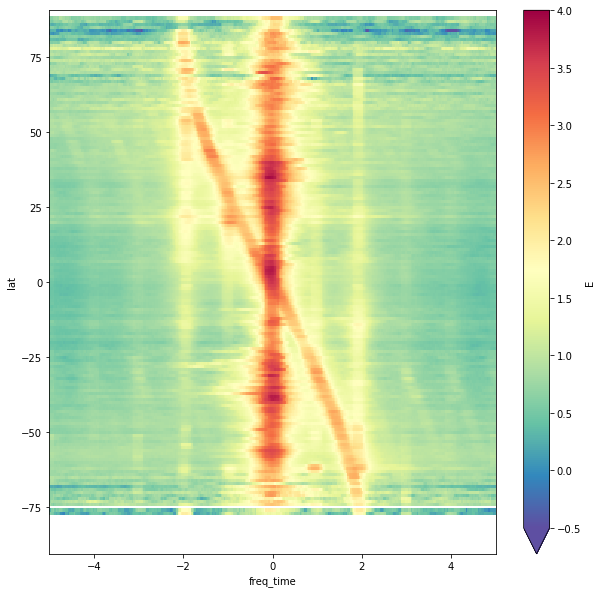

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
( np.log10(E*1e4).plot(ax=ax, vmin=-.5, vmax=4.,cmap='Spectral_r') )
ax.set_xlim([-5,5])

In [24]:
E['f'] = eut.coriolis(E.lat, signed=True)
E['f_cpd'] = E.f*86400./2./np.pi
E['nfreq_time'] = E.freq_time / E.f_cpd

(-3, 3)

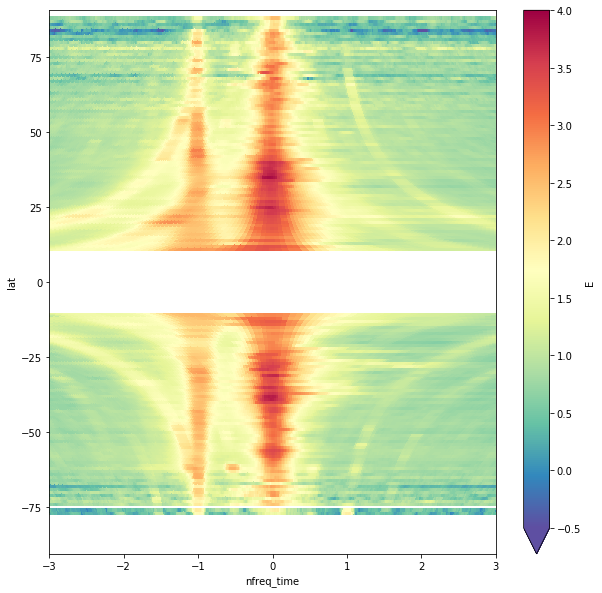

In [25]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
( np.log10(E.where(E.lat>10, drop=True)*1e4)
 .plot(ax=ax, x='nfreq_time', y='lat', 
                       vmin=-.5, vmax=4.,cmap='Spectral_r') )
( np.log10(E.where(E.lat<-10, drop=True)*1e4)
 .plot(ax=ax, x='nfreq_time', y='lat', 
                       vmin=-.5, vmax=4.,cmap='Spectral_r', add_colorbar=False) )
ax.set_xlim([-3,3])

## find inertial peak and bandwidth

In [26]:
dE = E.to_dataset()

In [27]:
dE

<xarray.Dataset>
Dimensions:     (freq_time: 721, lat: 181)
Coordinates:
  * lat         (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * freq_time   (freq_time) float64 -11.98 -11.95 -11.92 ... 11.92 11.95 11.98
    f           (lat) float64 -0.0001458 -0.0001458 ... 0.0001458 0.0001458
    f_cpd       (lat) float64 -2.005 -2.005 -2.004 -2.003 ... 2.004 2.005 2.005
    nfreq_time  (freq_time, lat) float64 5.975 5.976 5.979 ... 5.979 5.976 5.975
Data variables:
    E           (lat, freq_time) float64 dask.array<shape=(181, 721), chunksize=(14, 721)>

In [28]:
imax = ( dE.E.where(np.abs(dE.freq_time + dE.f_cpd)<.2).fillna(-1.)
                 .argmax('freq_time') )
dE['freq_max'] = dE.freq_time.isel(freq_time=imax).rename('freq_max')
dE['Emax'] = dE.E.isel(freq_time=imax)

In [52]:
Ei = (dE.where(np.abs(dE.freq_time - dE.freq_max)<1.)
      .where(dE.freq_time>dE.freq_max)) #.fillna(-1.)
Ei_rev = (dE.where(np.abs(dE.freq_time - dE.freq_max)<1.)
            .where(dE.freq_time<dE.freq_max) #.fillna(1e10)
            .sortby('freq_time', ascending=False) )
dE['freq_half_1'] = Ei.freq_time.isel(freq_time=(Ei.E<Ei.Emax/2.).argmax('freq_time'))
dE['freq_half_0'] = Ei_rev.freq_time.isel(freq_time=(Ei_rev.E<Ei_rev.Emax/2.).argmax('freq_time'))

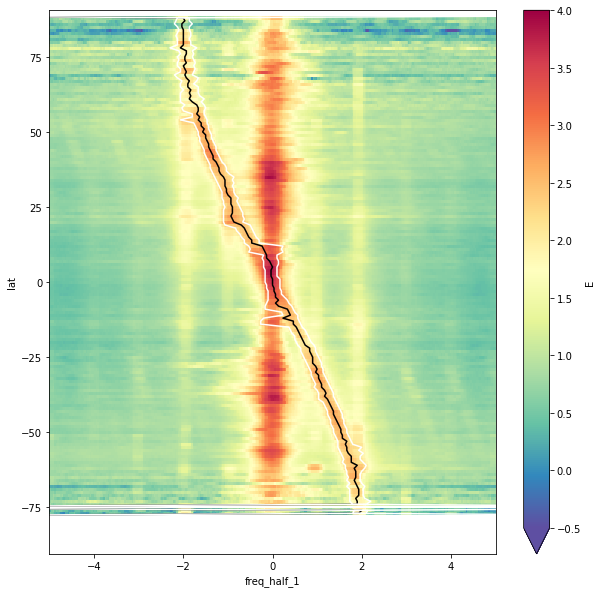

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
( np.log10(dE.E*1e4).plot(ax=ax, vmin=-.5, vmax=4.,cmap='Spectral_r') )
ax.set_xlim([-5,5])

dE.freq_max.plot(y='lat',color='k')
dE.freq_half_0.plot(y='lat',color='w')
dE.freq_half_1.plot(y='lat',color='w')

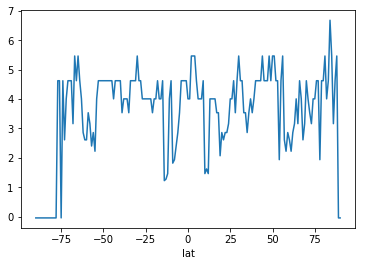

In [61]:
(1./(dE.freq_half_1-dE.freq_half_0-1/12.)).plot()

In [38]:
dE = dE.persist()

(-6.0, 6.0)

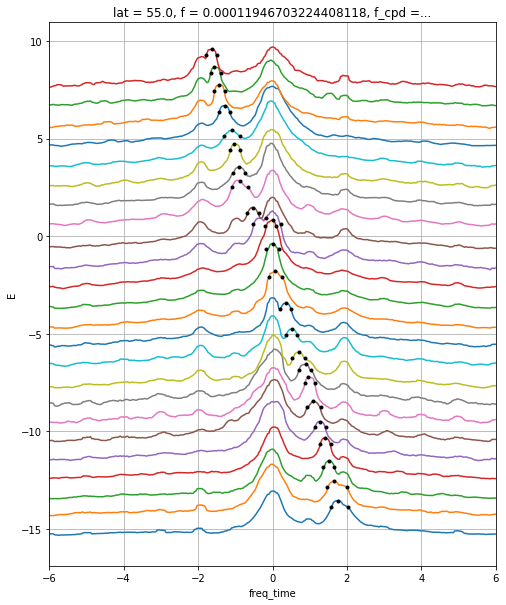

In [58]:
fig, ax = plt.subplots(1,1,figsize=(8,10))
for lat in np.arange(-60.,60.,5.):
    offset = lat/5.
    (np.log10(dE.E.sel(lat=lat))+offset).plot(ax=ax) #,color='k')
    ax.plot(dE.freq_max.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat))+offset), 
            marker='.',color='k')
    #ax.plot(dE.freq_max.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat)/2.)+offset), 
    #        marker='.',color='k')
    ax.plot(dE.freq_half_0.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat)/2.)+offset), 
            marker='.',color='k')
    ax.plot(dE.freq_half_1.sel(lat=lat), (np.log10(dE.Emax.sel(lat=lat)/2.)+offset), 
            marker='.',color='k')
ax.grid()
ax.set_xlim(-6.,6.)

In [195]:
def _bin1d(bins, v, vbin, weights=True):
    if weights:
        w = v
    else:
        w = np.ones_like(v)
    h, edges = np.histogram(vbin, bins=bins, weights=w, density=False)
    return h[None,:]

def bin1d(v, vbin, bins, weights, bin_dim='bin_dim', name='binned_array', core_dim='TIME'):
    # wrapper around apply_ufunc
    dims = [core_dim] # core dim
    bins_c = (bins[:-1]+bins[1:])*.5
    out = xr.apply_ufunc(partial(_bin1d, bins), v, vbin, kwargs={'weights': weights},
                    output_core_dims=[[bin_dim]], output_dtypes=[np.float64], 
                    dask='parallelized',
                    input_core_dims=[dims, dims],
                    output_sizes={bin_dim: len(bins_c)})
    out = out.assign_coords(**{bin_dim: bins_c}).rename(name)
    return out

In [175]:
#E_lat.mean('index')

In [196]:
E_lat = bin1d(ds.E, ds.LAT.mean('TIME')+0.*ds.E, lat_bins, False, bin_dim='lat_bins', 
                name='E_binned', core_dim='index').mean('index')

ValueError: dimension 'index' on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, rechunk into a single dask array chunk along this dimension, i.e., ``.rechunk({'index': -1})``, but beware that this may significantly increase memory usage.

In [182]:
E_lat

<xarray.DataArray 'E_binned' (freq_time: 721, lat_bins: 181)>
dask.array<shape=(721, 181), dtype=float64, chunksize=(721, 181)>
Coordinates:
  * freq_time  (freq_time) float64 -11.98 -11.95 -11.92 ... 11.92 11.95 11.98
  * lat_bins   (lat_bins) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0

In [178]:
E_lat.values.shape

(181,)

In [163]:
E_lat.s

<xarray.DataArray 'E_binned' (freq_time: 721, lat_bins: 181)>
dask.array<shape=(721, 181), dtype=float64, chunksize=(721, 181)>
Coordinates:
  * freq_time  (freq_time) float64 -11.98 -11.95 -11.92 ... 11.92 11.95 11.98
  * lat_bins   (lat_bins) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0

In [169]:
E_lat.plot(x='freq_time',y='lat_bins')

ValueError: axes don't match array

In [153]:
fbins = np.arange(0.,10.,.1)
#bin1d(ds.E, ds.LAT, fbins, False, bin_dim='nfreq', 
#      name='E_binned', core_dim=['freq_time'])
E_nfreq = bin1d(ds.E, ds.nfreq_time, fbins, False, bin_dim='nfreq', 
                name='E_binned', core_dim='freq_time').mean('index')

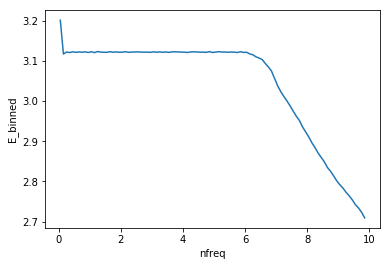

In [154]:
np.log10(E_nfreq).plot()

In [134]:
#ds.stack(points=['index','freq_time']).groupby_bins('nfreq_time', fbins).mean().E
# memory error

<xarray.Dataset>
Dimensions:           (TIME: 721, freq_time: 721, index: 11327)
Coordinates:
  * TIME              (TIME) timedelta64[ns] 00:00:00 ... 30 days 00:00:00
  * freq_time         (freq_time) float64 -11.98 -11.95 -11.92 ... 11.95 11.98
Dimensions without coordinates: index
Data variables:
    LAT               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(500, 721)>
    LON               (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(500, 721)>
    U                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(500, 721)>
    V                 (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(500, 721)>
    LAT_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(500, 721)>
    LON_ERR           (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(500, 721)>
    U_ERR             (index, TIME) float64 dask.array<shape=(11327, 721), chunksize=(500, 721)>
    V_ERR          

In [8]:
ncfile = data_dir+'raw/driftertrajWMLE_1.02_block1.nc'
ds = xr.open_mfdataset(data_dir+'raw/driftertrajWMLE_1.02_block*.nc')
ds = ds.chunk({'TIME':24*1000})
ds['GPS'] = (0. + ds.U*0.).astype(int)
ds_ARGOS = ds
#print(ds)

In [9]:
ds = xr.concat([ds_GPS, ds_ARGOS], dim='TIME')
ds['LON'] = eut.fix_lon_bounds(ds['LON'])

In [10]:
print('Dataset size = %.1f GB' %(ds.nbytes/1e9))
ds

Dataset size = 15.5 GB


<xarray.Dataset>
Dimensions:  (TIME: 148752886)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2001-07-01T02:00:00 ... NaT
Data variables:
    ID       (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LAT      (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LON      (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LAT_ERR  (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    LON_ERR  (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    U        (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    V        (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    U_ERR    (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    V_ERR    (TIME) float64 dask.array<shape=(148752886,), chunksize=(24000,)>
    GAP      (TIME) timedelta64[ns] dask.array<shape=(148752886,), chunksize=(24000,)>
    DROGUE   (TIME) float64 dask.array<shape=(148752886,), chu

In [11]:
# convert to dataframe
df = ds.to_dask_dataframe()
df
# could persist right away

,TIME,ID,LAT,LON,LAT_ERR,LON_ERR,U,V,U_ERR,V_ERR,GAP,DROGUE,GPS
npartitions=6199,,,,,,,,,,,,,
0,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,timedelta64[ns],float64,int64
24000,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148734737,...,...,...,...,...,...,...,...,...,...,...,...,...
148752885,...,...,...,...,...,...,...,...,...,...,...,...,...


---

## start massaging to get diagnostics

In [12]:
# add velocity products
df['U2'] = df['U']*df['U']
df['V2'] = df['V']*df['V']
df['UV'] = df['U']*df['V']

In [13]:
# bin longitude and latitude for groupby
df['LON_binned'] = df['LON'].map_partitions(pd.cut, lon_bins, meta=(None,'f8'))
df['LAT_binned'] = df['LAT'].map_partitions(pd.cut, lat_bins, meta=(None,'f8'))

In [14]:
df = df.persist()
# 67GB in memory at this stage

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/blockwise.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  contains = index in indices
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/blockwise.py:595: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  sub[blockwise_token(i)] = blockwise_token(indices.index(index))


---

## compute diagnostics

In [15]:
df_meancount = (df.drop(['ID','TIME'],axis=1).groupby(['LON_binned','LAT_binned'])
                .aggregate(['mean','count']).compute())
#df_mean = df.groupby(['LON_binned','LAT_binned']).mean().compute()

In [16]:
df_meancount.head()

LAT               LON        \
                                      mean count        mean count   
LON_binned       LAT_binned                                          
(-180.5, -179.5] (-77.5, -76.5] -76.931941    79 -179.718952    79   
                 (-76.5, -75.5] -75.956183    55 -179.692855    55   
                 (-75.5, -74.5] -74.985907    72 -179.810330    72   
                 (-74.5, -73.5] -73.770683     3 -179.935097     3   
                 (-71.5, -70.5] -70.511522    37 -179.685926    37   

                                    LAT_ERR           LON_ERR               U  \
                                       mean count        mean count      mean   
LON_binned       LAT_binned                                                     
(-180.5, -179.5] (-77.5, -76.5]  100.658228    79  445.392405    79 -0.041994   
                 (-76.5, -75.5]  116.745455    55  480.945455    55 -0.002022   
                 (-75.5, -74.5]  139.513889    72  537.680556    72 -0.006481   
                 (-74.5, -73.5]  181.333333     3  647.666667     3  0.152533   
                 (-71.5, -70.5]  146.378378    37  439.162162    37 -0.033059   

                                       ...    DROGUE        GPS        \
                                count  ...      mean count mean count   
LON_binned       LAT_binned            ...                              
(-180.5, -179.5] (-77.5, -76.5]    79  ...  1.000000    79  1.0    79   
                 (-76.5, -75.5]    55  ...  0.254545    55  1.0    55   
                 (-75.5, -74.5]    72  ...  0.000000    72  1.0    72   
                 (-74.5, -73.5]     3  ...  0.000000     3  1.0     3   
                 (-71.5, -70.5]    37  ...  0.783784    37  1.0    37   

                                       U2              V2              UV  \
                                     mean count      mean count      mean   
LON_binned       LAT_binned                                                 
(-180.5, -179.5] (-77.5, -76.5]  0.023002    79  0.021053    79 -0.003133   
                 (-76.5, -75.5]  0.026543    55  0.052648    55  0.007060   
                 (-75.5, -74.5]  0.029945    72  0.085887    72  0.004302   
                 (-74.5, -73.5]  0.023363     3  0.070575     3  0.039946   
                 (-71.5, -70.5]  0.015767    37  0.019860    37 -0.014477   

                                       
                                count  
LON_binned       LAT_binned            
(-180.5, -179.5] (-77.5, -76.5]    79  
                 (-76.5, -75.5]    55  
                 (-75.5, -74.5]    72  
                 (-74.5, -73.5]     3  
                 (-71.5, -70.5]    37  

[5 rows x 28 columns]

In [36]:
datadict = {v: (['lon', 'lat'], df_meancount[v]['mean'].reindex(lonlat_idx).unstack().values) for v in ['U','V', 'U2', 'V2', 'UV']}
datadict['COUNT'] = (['lon', 'lat'], df_meancount['U']['count'].reindex(lonlat_idx).unstack().values)

In [37]:
ds = xr.Dataset(datadict, coords = {'lon': lon_c, 'lat': lat_c})

In [38]:
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    U        (lon, lat) float64 nan nan nan nan ... nan -0.02582 0.2797 -0.0807
    V        (lon, lat) float64 nan nan nan nan ... nan 0.1025 -0.0283 -0.053
    U2       (lon, lat) float64 nan nan nan nan ... nan 0.01712 0.07918 0.006512
    V2       (lon, lat) float64 nan nan nan nan ... 0.01571 0.0008749 0.002809
    UV       (lon, lat) float64 nan nan nan nan ... -0.001538 -0.008177 0.004277
    COUNT    (lon, lat) float64 nan nan nan nan nan nan ... nan nan 26.0 2.0 1.0

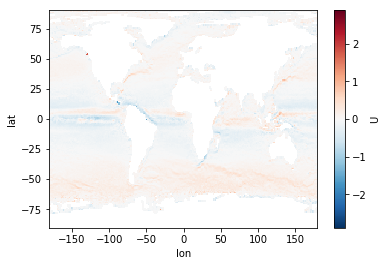

In [39]:
ds.U.plot(x='lon',y='lat')

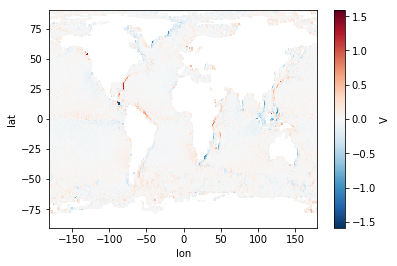

In [40]:
ds.V.plot(x='lon',y='lat')

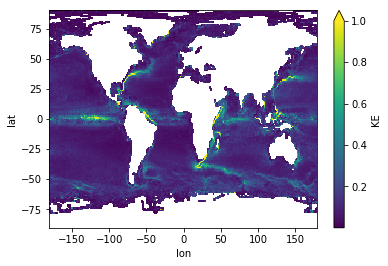

In [41]:
(ds.U2+ds.V2).rename('KE').plot(x='lon',y='lat',vmax=1.)

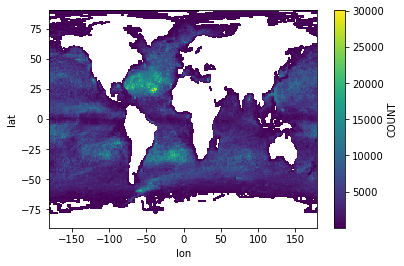

In [42]:
ds.COUNT.plot(x='lon',y='lat')

In [43]:
# add depth
depth = xr.open_dataset(eut.work_data_dir+'bathy/ETOPO1_Ice_g_gmt4.grd')
depth['x2'] = (depth.x+0.*depth.y).transpose()
depth['y2'] = (0.*depth.x+depth.y).transpose()
depth

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 ...
    x2       (y, x) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
    y2       (y, x) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

In [44]:
# without averaging
depth_noav = depth.z.sel(x=ds.lon,y=ds.lat, method='nearest', tolerance=0.1)

# with averaging
h, edges1, edges2 = np.histogram2d(depth.x2.values.flatten(), depth.y2.values.flatten(), 
                                   bins=[lon_bins, lat_bins], weights=depth.z.values.flatten(), 
                                   density=False)
hcount, edges1, edges2 = np.histogram2d(depth.x2.values.flatten(), depth.y2.values.flatten(), 
                                       bins=[lon_bins, lat_bins],
                                       density=False)
ds['depth'] = xr.DataArray((h/hcount), coords=[ds.lon,ds.lat])

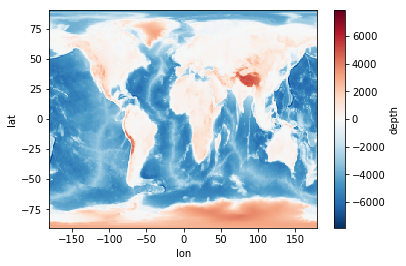

In [45]:
ds.depth.plot(x='lon',y='lat')

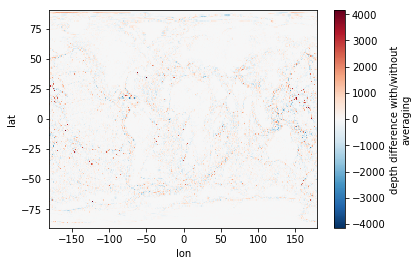

In [46]:
(depth_noav - ds.depth).rename('depth difference with/without averaging').plot(x='lon',y='lat')

---

## store dataset

In [47]:
# store
ds.to_netcdf(data_dir+'single_stats.nc', mode='w')
ds

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360)
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
Data variables:
    U        (lon, lat) float64 nan nan nan nan ... nan -0.02582 0.2797 -0.0807
    V        (lon, lat) float64 nan nan nan nan ... nan 0.1025 -0.0283 -0.053
    U2       (lon, lat) float64 nan nan nan nan ... nan 0.01712 0.07918 0.006512
    V2       (lon, lat) float64 nan nan nan nan ... 0.01571 0.0008749 0.002809
    UV       (lon, lat) float64 nan nan nan nan ... -0.001538 -0.008177 0.004277
    COUNT    (lon, lat) float64 nan nan nan nan nan nan ... nan nan 26.0 2.0 1.0
    depth    (lon, lat) float64 2.792e+03 2.983e+03 ... -2.728e+03 -4.22e+03

In [62]:
cluster.close()

distributed.batched - INFO - Batched Comm Closed: in <closed TCP>: Stream is closed
